# Age Detection

## Setup

### Import Statements

In [1]:
import tensorflow as tf
from keras.preprocessing import image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'2.15.0'

### Notebook Presentation

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [4]:
df = pd.read_csv("./dataset/age_gender.csv")

In [5]:
df.sample(5)

,age,ethnicity,gender,img_name,pixels
8229,26,3,0,20170117154558934.jpg.chip.jpg,165 166 167 171 173 62 5 9 42 82 87 93 96 108 ...
18644,52,0,0,20170104212249957.jpg.chip.jpg,49 54 88 88 118 148 165 164 168 175 176 181 18...
16251,41,1,0,20170117140422547.jpg.chip.jpg,20 30 35 45 51 57 58 55 57 59 62 64 72 80 85 9...
9735,28,1,1,20170112230622262.jpg.chip.jpg,172 128 88 91 96 103 109 112 119 124 129 129 1...
14636,37,0,0,20170120221604091.jpg.chip.jpg,117 117 115 118 112 98 64 41 31 33 49 58 59 42...


## Preliminary Data Exploration

### Analyzing the Data

In [6]:
df.shape

(23705, 5)

In [7]:
df.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

In [8]:
df.isna().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [9]:
df.describe()

,age,ethnicity,gender
count,"23,705.00","23,705.00","23,705.00"
mean,33.30,1.27,0.48
std,19.89,1.35,0.50
min,1.00,0.00,0.00
25%,23.00,0.00,0.00
50%,29.00,1.00,0.00
75%,45.00,2.00,1.00
max,116.00,4.00,1.00


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


### Visualizing the Ages

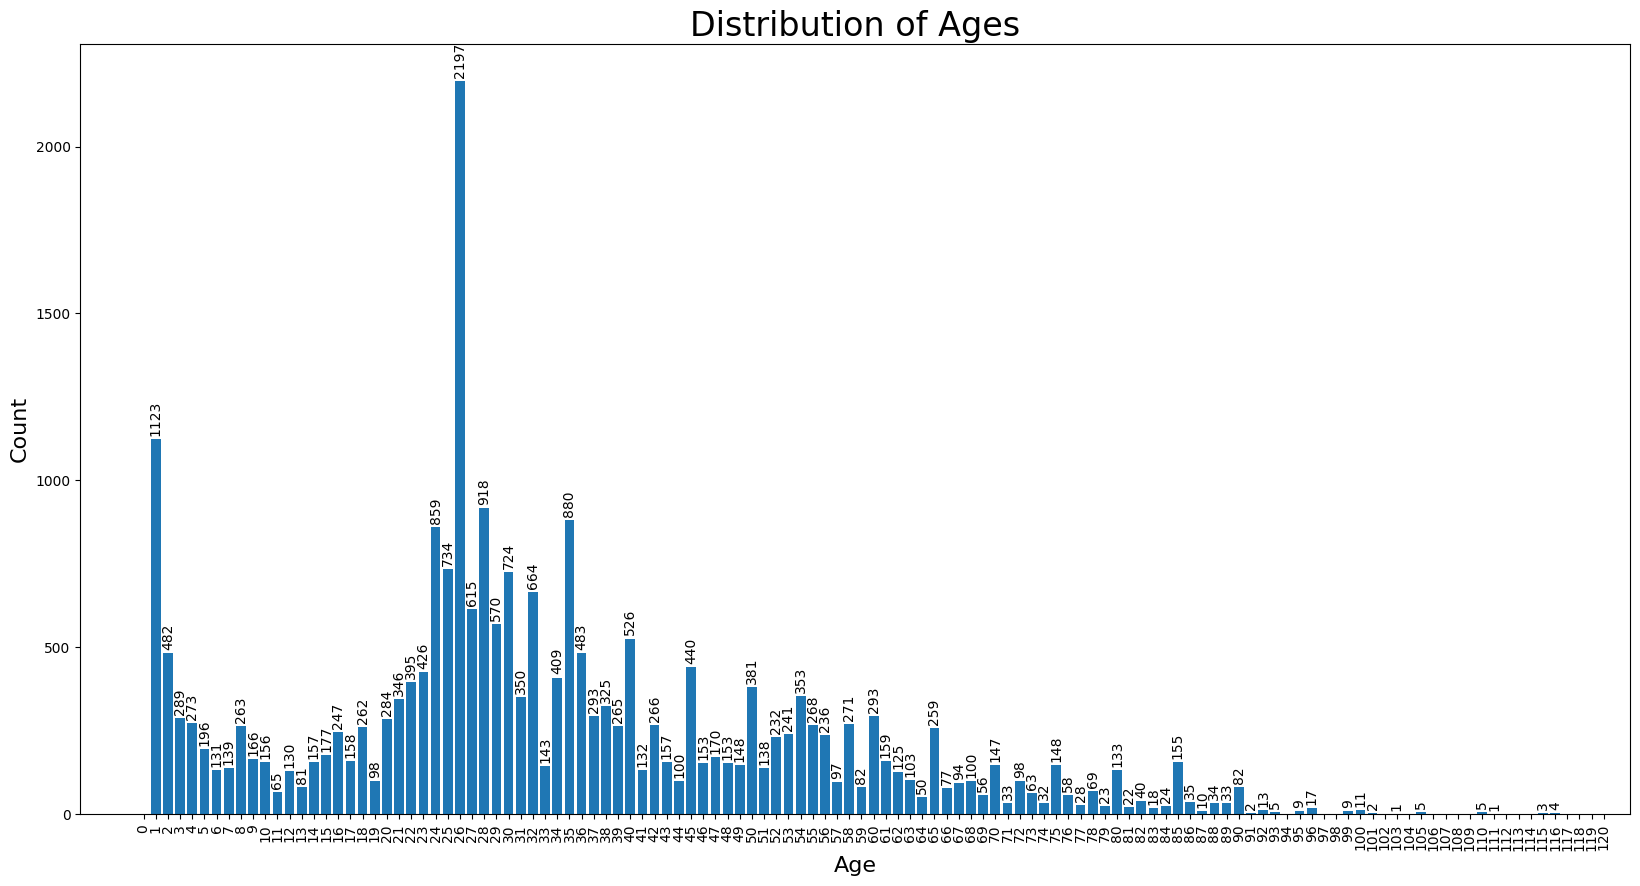

In [11]:
age_distribution = df['age'].value_counts()

plt.figure(figsize=(20, 10))
plt.bar(age_distribution.index, age_distribution.values)
plt.title("Distribution of Ages", fontsize=24)

for i, count in enumerate(age_distribution.values):
    plt.text(age_distribution.index[i], count + 10, str(count), ha='center', va='bottom', rotation=90)

plt.xticks(range(0, 121), rotation=90)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

## Data Preprocessing

### Binning of the Ages

In [12]:
age_bins = [0, 5, 18, 30, 45, 64, 120]
age_labels = [0, 1, 2, 3, 4, 5]

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

In [13]:
age_group_map = ['0 - 5', '6 - 18', '19 - 30', '31 - 45', '46 - 64', '65+']

In [14]:
df.sample(5)

,age,ethnicity,gender,img_name,pixels,age_group
13144,35,1,1,20170113001239705.jpg.chip.jpg,70 69 73 68 72 75 82 87 83 80 84 121 154 170 1...,3
15847,40,1,0,20170117135308283.jpg.chip.jpg,136 43 43 40 32 33 68 103 118 131 154 172 182 ...,3
18647,52,0,0,20170104212238236.jpg.chip.jpg,239 243 243 245 246 240 232 223 214 213 213 21...,4
23326,87,0,1,20170110181045529.jpg.chip.jpg,143 151 163 189 191 192 189 185 170 163 163 17...,5
21491,66,0,0,20170104213607429.jpg.chip.jpg,78 83 88 95 173 170 164 161 176 170 172 180 17...,5


In [15]:
df['age_group'].unique()

[0, 1, 5, 2, 3, 4]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

### Visualizing the Age Ranges

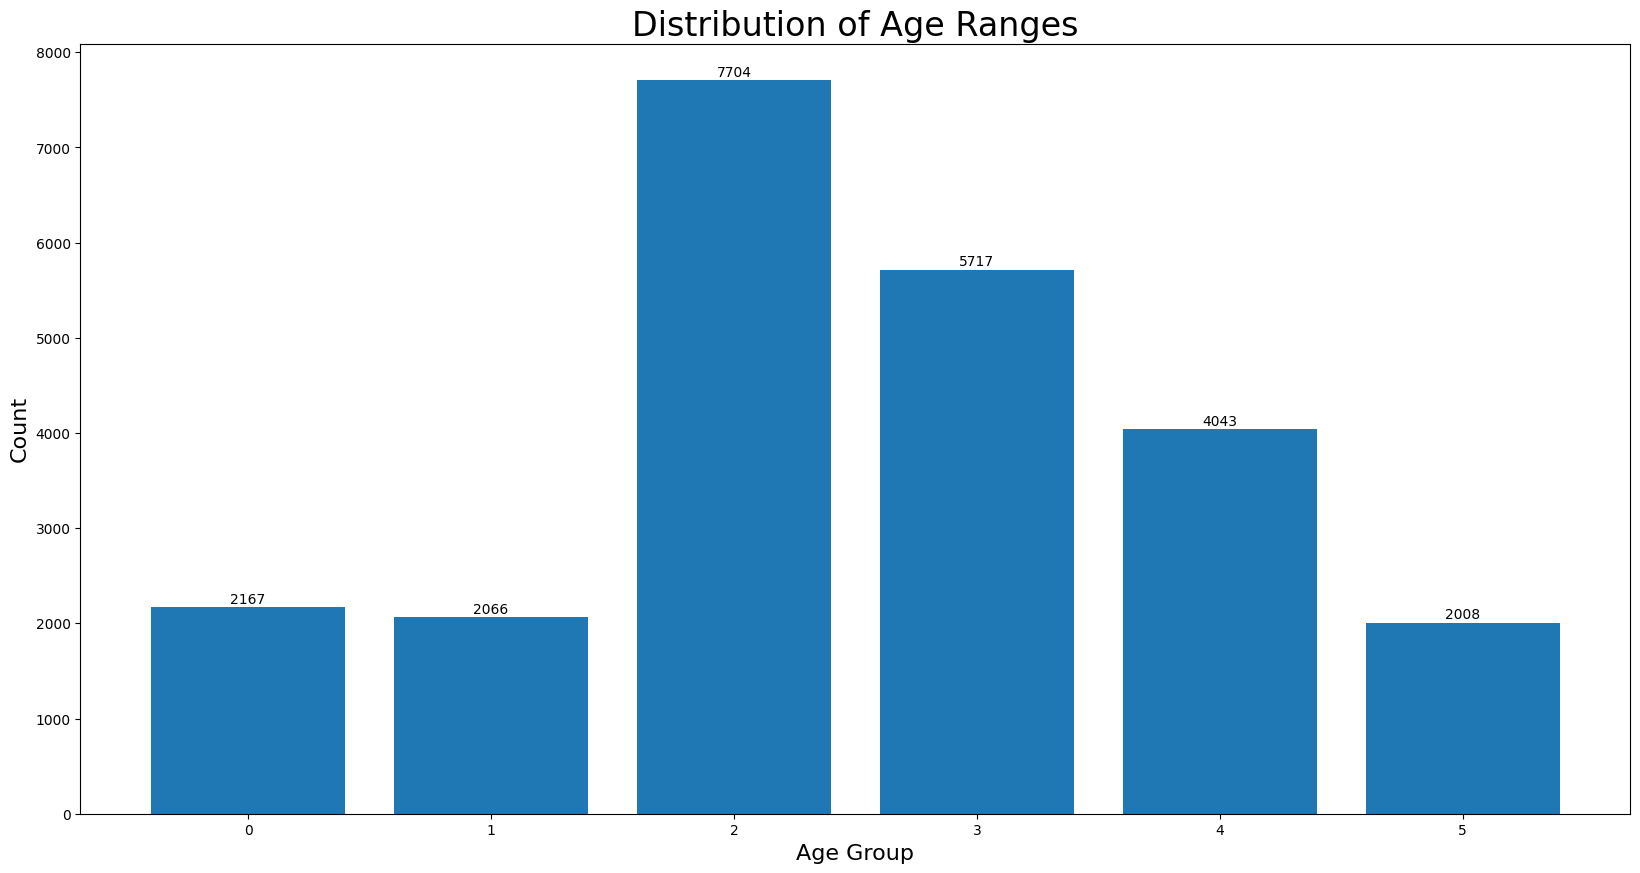

In [16]:
age_group_distribution = df['age_group'].value_counts().sort_index()

plt.figure(figsize=(20, 10))
plt.bar(age_group_distribution.index, age_group_distribution.values)
plt.title("Distribution of Age Ranges", fontsize=24)

for i, count in enumerate(age_group_distribution.values):
    plt.text(age_group_distribution.index[i], count + 10, str(count), ha='center', va='bottom')

plt.xticks(age_group_distribution.index)
plt.xlabel('Age Group', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

### Reshaping the Pixels Column

In [17]:
df['pixels'] = df['pixels'].apply(lambda x:  np.array(x.split(), dtype='float32'))

df['pixels'][0]

array([129., 128., 128., ..., 146., 146., 146.], dtype=float32)

In [18]:
X = np.array(df['pixels'].tolist())

X.shape

(23705, 2304)

In [19]:
X = X.reshape(-1, 48, 48, 1) # The images are 48x48 mono

X[0].shape

(48, 48, 1)

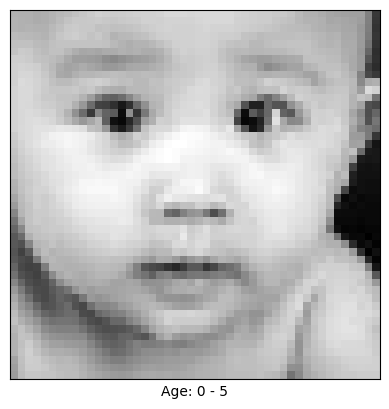

In [20]:
plt.imshow(X[0], cmap='gray')
plt.xlabel(f"Age: {age_group_map[df['age_group'][0]]}")

plt.xticks([])
plt.yticks([])
plt.grid(False)

### Training and Test Split

In [21]:
X = X / 255.0 # Normalizing the inputs
y = tf.keras.utils.to_categorical(np.array(df['age_group']), num_classes=6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

## Model Architecture

### Initializing the Model

In [22]:
age_detection_model = tf.keras.models.Sequential()

### Building the Model

In [23]:
age_detection_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 48, 1)))
age_detection_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
age_detection_model.add(tf.keras.layers.Dropout(0.2))

age_detection_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
age_detection_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
age_detection_model.add(tf.keras.layers.Dropout(0.2))


age_detection_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
age_detection_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
age_detection_model.add(tf.keras.layers.Dropout(0.2))


age_detection_model.add(tf.keras.layers.Flatten())

age_detection_model.add(tf.keras.layers.Dense(units=256, activation='relu'))
age_detection_model.add(tf.keras.layers.Dropout(0.5))

age_detection_model.add(tf.keras.layers.Dense(units=6, activation='softmax'))

### Compiling the Model

In [24]:
age_detection_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Model

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.3, min_lr=0.00001)

In [26]:
age_detection_model.fit(X_train, y_train, batch_size=16, validation_data=(X_test, y_test), epochs=100, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/100
1186/1186 [==============================] - 15s 11ms/step - loss: 1.3891 - accuracy: 0.4144 - val_loss: 1.1618 - val_accuracy: 0.5163 - lr: 0.0010
Epoch 2/100
1186/1186 [==============================] - 13s 11ms/step - loss: 1.1463 - accuracy: 0.5128 - val_loss: 1.0380 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 3/100
1186/1186 [==============================] - 13s 11ms/step - loss: 1.0724 - accuracy: 0.5374 - val_loss: 0.9681 - val_accuracy: 0.5897 - lr: 0.0010
Epoch 4/100
1186/1186 [==============================] - 13s 11ms/step - loss: 1.0183 - accuracy: 0.5628 - val_loss: 0.9691 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 5/100
1186/1186 [==============================] - 13s 11ms/step - loss: 0.9922 - accuracy: 0.5704 - val_loss: 0.9121 - val_accuracy: 0.6011 - lr: 0.0010
Epoch 6/100
1186/1186 [==============================] - 13s 11ms/step - loss: 0.9638 - accuracy: 0.5830 - val_loss: 0.8987 - val_accuracy: 0.6125 - lr: 0.0010
Epoch 7/100
1186/1186 [=================

### Saving the model

In [27]:
age_detection_model.save("./age_model")

INFO:tensorflow:Assets written to: ./age_model\assets


INFO:tensorflow:Assets written to: ./age_model\assets


## Analysis

### Performance

In [28]:
loss, acc = age_detection_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss}')
print(f'Test Accuracy: {acc}')

Test loss: 0.8057082891464233
Test Accuracy: 0.6517612338066101


### Summary

In [29]:
age_detection_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_59 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_60 (Dropout)        (None, 10, 10, 64)      

### Testing out the Model

<p align='center'>
    <img src='./assets/model_test_img.jpg'>
</p>

In [30]:
test_image = image.load_img('./assets/model_test_img.jpg',target_size=(48, 48), color_mode='grayscale')

test_image = image.img_to_array(test_image)

test_image = np.expand_dims(test_image, axis=0)

In [31]:
prediction = age_detection_model.predict(test_image / 255.0)

predicted_class = np.argmax(prediction)

print("Predicted Class:", age_group_map[predicted_class])

1/1 [==============================] - 0s 17ms/step
Predicted Class: 65+
